In [55]:
from kalmanODE_jax import *
from jax.config import config
import jax.scipy as jsp
from math import sin
import jax.numpy as jnp
config.update("jax_enable_x64", True)

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from rodeo.ibm import ibm_init
from rodeo.utils.utils import rand_mat, indep_init, zero_pad
from scipy.integrate import odeint
from rodeo.cython.KalmanODE import KalmanODE as KalmanODE_blas
import sys
sys.path.append("..")
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [57]:

def fun(x, t, theta=None, x_out=None):
    if x_out is None:
        x_out = jnp.zeros(1)
    x_out[0] = sin(2*t) - x[0]
    return x_out

def f(x_t, t):
    return [x_t[1], sin(2*t) - x_t[0]]

In [58]:
def jaxfun(x, t, theta=None, x_out=None):
    if x_out is None:
        x_out = jnp.zeros(1)
    x_out = index_update(x_out, index[0], sin(2*t) - x[0])
    return x_out

In [59]:
# LHS vector of ODE
w_mat = np.array([[0.0, 0.0, 1.0]], order='F')

# These parameters define the order of the ODE and the CAR(p) process
n_deriv = [2]
n_deriv_prior = [4]

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 100
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = [.5]

# Initial value, x0, for the IVP
x0 = np.array([-1., 0., 1.])

# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# All necessary parameters are in kinit, namely, T, c, R, W
W = zero_pad(w_mat, n_deriv, n_deriv_prior)
x0_state = zero_pad(x0, n_deriv, n_deriv_prior)
kinit = ibm_init(dt, n_deriv_prior, sigma)
#kinit = indep_init(ode_init, n_deriv_prior)

In [60]:
z_state = rand_mat(2*n_eval, sum(n_deriv_prior))
kalmanode = KalmanODE_blas(W = W, tmin = tmin, tmax = tmax, n_eval = n_eval, ode_fun = fun, **kinit)
kalmanode.z_state = z_state
ksim_cy = kalmanode.solve_sim(x0_state, method="rodeo")

In [61]:
ksim_jax = \
    solve_sim(jaxfun, jnp.array(x0_state), tmin, tmax, n_eval, jnp.array(kinit['wgt_state']), 
              jnp.array(kinit['mu_state']), jnp.array(kinit['var_state']), 
              jnp.array(W), jnp.array(z_state), theta=None)

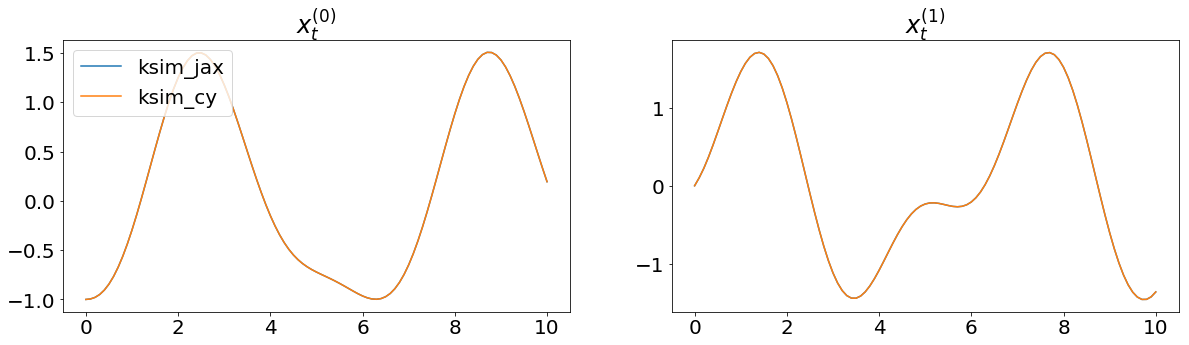

In [62]:
# ode function in odeint format
tseq = np.linspace(tmin, tmax, n_eval+1)
ode = odeint(f, [-1, 0], tseq)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(tseq, ksim_jax[:,0], label='ksim_jax')
axs[0].plot(tseq, ksim_cy[:,0], label='ksim_cy')
axs[0].set_title("$x^{(0)}_t$")
axs[0].legend(loc='upper left')
axs[1].plot(tseq, ksim_jax[:,1], label='ksim_jax')
axs[1].plot(tseq, ksim_cy[:,1], label='ksim_cy')
axs[1].set_title("$x^{(1)}_t$")
plt.show()

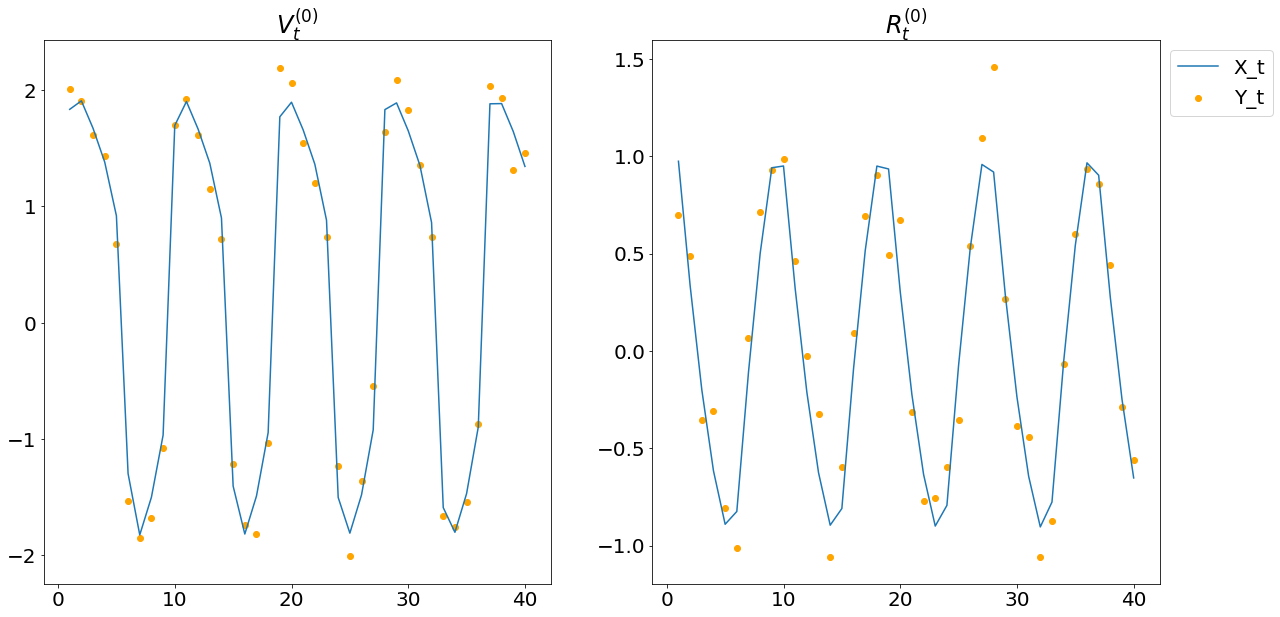

In [63]:
import sys
sys.path.append('../../examples')
from inference import inference

def fitz(X_t, t, theta, out=None):
    "FN ODE function with optional overwriting of output."
    if out is None:
        out = np.empty(2)
    a, b, c = theta
    n_deriv1 = len(X_t)//2
    V, R = X_t[0], X_t[n_deriv1]
    out[0] = c*(V - V*V*V/3 + R)
    out[1] = -1/c*(V - a + b*R)
    return out

n_deriv = [1, 1] # Total state
n_obs = 2 # Total measures
n_deriv_prior = [3, 3]
p = sum(n_deriv_prior)
state_ind = [0, 3] # Index of 0th derivative of each state

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0 
tmax = 40

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 2
sigma = [.1]*n_var

# Initial value, x0, for the IVP
x0 = np.array([-1., 1.])
v0 = np.array([1, 1/3])
X0 = np.ravel([x0, v0], 'F')

# pad the inputs
w_mat = jnp.array([[0., 1., 0., 0.], [0., 0., 0., 1.]])
W = zero_pad(w_mat, n_deriv, n_deriv_prior)

# logprior parameters
theta_true = jnp.array([0.2, 0.2, 3]) # True theta
n_theta = len(theta_true)
phi_sd = jnp.ones(n_theta) 

# Observation noise
gamma = 0.2

# Number of samples to draw from posterior
n_samples = 100000

# Initialize inference class and simulate observed data
inf = inference(state_ind, tmin, tmax, fitz)
Y_t, X_t = inf.simulate(fitz, x0, theta_true, gamma)
tseq = np.linspace(1, tmax, 40)
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].plot(tseq, X_t[:,0], label = 'X_t')
axs[0].scatter(tseq, Y_t[:,0], label = 'Y_t', color='orange')
axs[0].set_title("$V^{(0)}_t$")
axs[1].plot(tseq, X_t[:,1], label = 'X_t')
axs[1].scatter(tseq, Y_t[:,1], label = 'Y_t', color='orange')
axs[1].set_title("$R^{(0)}_t$")
axs[1].legend(loc='upper left', bbox_to_anchor=[1, 1])


In [64]:
def jaxfitz(X_t, t, theta, x_out=None):
    "FN ODE function with optional overwriting of output."
    if x_out is None:
        x_out = jnp.zeros(2)
    a, b, c = theta
    n_deriv1 = len(X_t)//2
    V, R = X_t[0], X_t[n_deriv1]
    x_out = index_update(x_out, index[0], c*(V - V*V*V/3 + R))   
    x_out = index_update(x_out, index[1], -1/c*(V - a + b*R))
    return x_out

In [96]:
h = 0.1
ode_init = ibm_init(h, n_deriv_prior, sigma)
x0_state = zero_pad(X0, n_deriv, n_deriv_prior)
kinit = indep_init(ode_init, n_deriv_prior)
n_eval = int((tmax-tmin)/h)
z_state = rand_mat(2*n_eval, sum(n_deriv_prior))
kalman_jax = solve_sim(jaxfitz, jnp.array(x0_state), tmin, tmax, n_eval, jnp.array(kinit['wgt_state']), \
              jnp.array(kinit['mu_state']), jnp.array(kinit['var_state']), \
              jnp.array(W), jnp.array(z_state), theta=theta_true)
#phi_hat, phi_var = inf.phi_fit(Y_t, x0_state, hlst[i], theta_true, phi_sd, gamma, True)

In [99]:
kalmanode = KalmanODE_blas(W, tmin, tmax, n_eval, fitz, **kinit)
kalmanode.z_state = z_state
kalman_cy = kalmanode.solve_sim(x0_state, W, theta_true, method="rodeo")

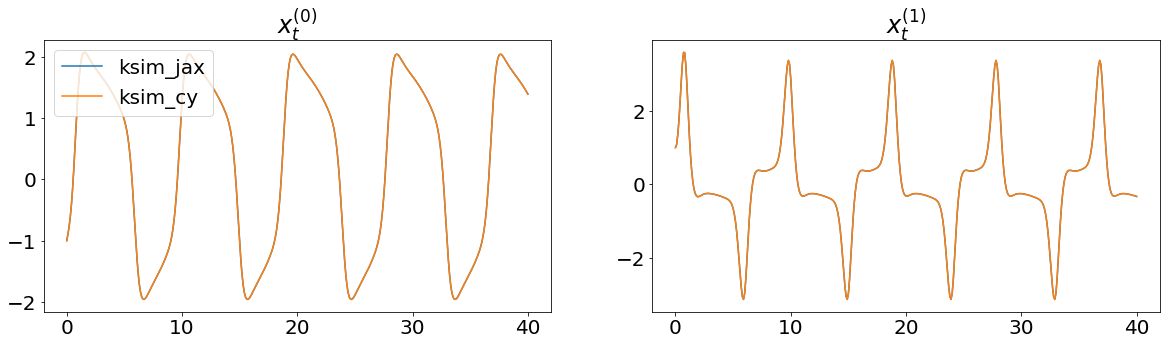

In [100]:
# ode function in odeint format
tseq = np.linspace(tmin, tmax, n_eval+1)
ode = odeint(f, [-1, 0], tseq)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(tseq, kalman_jax[:,0], label='ksim_jax')
axs[0].plot(tseq, kalman_cy[:,0], label='ksim_cy')
axs[0].set_title("$x^{(0)}_t$")
axs[0].legend(loc='upper left')
axs[1].plot(tseq, kalman_jax[:,1], label='ksim_jax')
axs[1].plot(tseq, kalman_cy[:,1], label='ksim_cy')
axs[1].set_title("$x^{(1)}_t$")
plt.show()

In [ ]:
%timeit -o _ = \
    solve_sim(jaxfitz, jnp.array(x0_state), tmin, tmax, n_eval, jnp.array(kinit['wgt_state']), \
              jnp.array(kinit['mu_state']), jnp.array(kinit['var_state']), \
              jnp.array(W), jnp.array(z_state), theta=theta_true)

In [66]:
kalmanode = KalmanODE_blas(W, tmin, tmax, n_eval, fitz, **kinit)
kalmanode.z_state = z_state
kalman_fitz_cy = %timeit -o _ = kalmanode.solve(x0_state, W, theta)

5.92 ms ± 84.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [113]:
def loglike(x, mean, var):
    r"Calculate the loglikelihood of the lognormal distribution."
    return jnp.sum(jsp.stats.norm.logpdf(x=x, loc=mean, scale=var))

def thinning(data_tseq, ode_tseq, X):
    r"Thin a highly discretized ODE solution to match the observed data."
    data_i = 0
    ode_i = 0
    diff = 1000
    ind = jnp.zeros(len(data_tseq), dtype=int)
    while data_i < len(data_tseq) and ode_i < len(ode_tseq):
        if data_tseq[data_i] > ode_tseq[ode_i]:
            diff = min(diff, abs(data_tseq[data_i] - ode_tseq[ode_i]))
            ode_i+=1
        else:
            if diff > abs(data_tseq[data_i] - ode_tseq[ode_i]):
                ind[data_i] = ode_i
            else:
                ind[data_i] = ode_i-1
            data_i+=1
            diff = 1000
    return X[ind,:]

def kalman_nlpost(phi, Y_t, x0, step_size, phi_mean, phi_sd, gamma):
    r"Compute the negative loglikihood of :math:`Y_t` using the KalmanODE."
    theta = jnp.exp(phi)
    X_t = solve_sim(jaxfitz, jnp.array(x0_state), tmin, tmax, n_eval, jnp.array(kinit['wgt_state']), 
                    jnp.array(kinit['mu_state']), jnp.array(kinit['var_state']), 
                    jnp.array(W), jnp.array(z_state), theta=theta)
    X_t = X_t[::int(1/step_size)][1:][:, state_ind]
    lp = loglike(Y_t, X_t, gamma)
    lp += loglike(phi, phi_mean, phi_sd)
    return -lp
def kalman_nlpost2(phi, Y_t, x0, step_size, phi_mean, phi_sd, gamma):
    r"Compute the negative loglikihood of :math:`Y_t` using the KalmanODE."
    theta = jnp.exp(phi)
    kalmanode = KalmanODE_blas(W, tmin, tmax, n_eval, fitz, **kinit)
    kalmanode.z_state = z_state
    X_t = kalmanode.solve_sim(x0_state, W, theta, method="rodeo")
    X_t = X_t[::int(1/step_size)][1:][:, state_ind]
    lp = loglike(Y_t, X_t, gamma)
    lp += loglike(phi, phi_mean, phi_sd)
    return -lp

In [114]:
phi_mean = jnp.log(theta_true)
n_theta = len(theta_true)
kalman_nlpost(phi_mean + .1, Y_t, x0_state, h, phi_mean, phi_sd, gamma)

DeviceArray(1183.97211007, dtype=float64)

In [115]:
kalman_nlpost2(phi_mean + .1, Y_t, x0_state, h, phi_mean, phi_sd, gamma)

DeviceArray(1183.97211006, dtype=float64)

In [121]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
phi_init = jnp.zeros(3)
phi_mean = jnp.log(theta_true)
test = grad(kalman_nlpost)(phi_init, Y_t, x0_state, h, phi_mean, phi_sd, gamma)

In [117]:
import scipy as sp
kalman_grad = grad(kalman_nlpost)
opt_res = sp.optimize.minimize(kalman_nlpost, phi_mean + .1,
                               args=(Y_t, x0_state, h, phi_mean, phi_sd, gamma),
                               method='BFGS',
                               jac=kalman_grad)